In [ ]:
!pip install arch --quiet
!pip install statsmodels --quiet

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import arch
from tqdm import tqdm

In [ ]:
# Assets
bonds_prices_df = pd.read_csv('vars/bonds_df.csv', parse_dates=['Date']).set_index('Date')
stock_prices_df = pd.read_csv('vars/df_stocks_fx.csv', parse_dates=['Date']).set_index('Date')
bonds_prices_df.sort_index(ascending=True, inplace=True)
stock_prices_df.sort_index(ascending=True, inplace=True)

# Risk factors
bonds_risk_factors = pd.read_csv('vars/df_risk_factors_bonds.csv', parse_dates=['datetime'])
bonds_risk_factors['datetime'] = pd.to_datetime(bonds_risk_factors['datetime'].dt.date)
bonds_risk_factors = bonds_risk_factors.set_index('datetime') / 100
stock_risk_factors = pd.read_csv('vars/df_risk_factors.csv', parse_dates=['Date']).set_index('Date')
bonds_risk_factors.sort_index(ascending=True, inplace=True)
stock_risk_factors.sort_index(ascending=True, inplace=True)

bonds_prices_df.shape, bonds_risk_factors.shape, stock_prices_df.shape, stock_risk_factors.shape

((1515, 5), (1515, 12), (1566, 12), (1566, 3))

### Convert prices to returns 

In [ ]:
stocks_prices_returns = stock_prices_df.pct_change()
bonds_returns = bonds_prices_df.diff()

stocks_factors_returns = stock_risk_factors.pct_change()
bonds_factors_returns = bonds_risk_factors.diff()

<AxesSubplot:xlabel='Date'>

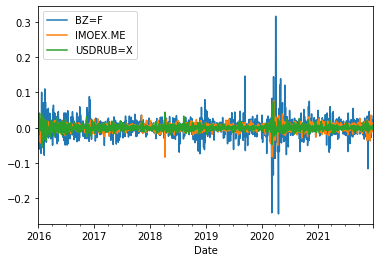

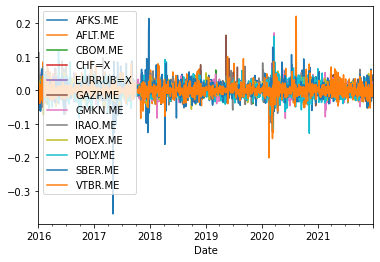

In [ ]:
stocks_factors_returns.plot()
stocks_prices_returns.plot()

### Dimensionality reduction for bonds 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(bonds_factors_returns.dropna())
# plt.plot(np.arange(1, len(pca.components_) + 1), np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel("Number of components")
# plt.ylabel("Proportion of explained variance")
# plt.grid()

In [ ]:
def reduce_dimensions(df, n_components=2):
    df_reduced = PCA(n_components).fit_transform(bonds_factors_returns.fillna(method='bfill'))
    cols = [f'component_{i}' for i in range(n_components)]
    return pd.DataFrame(df_reduced, index=df.index, columns=cols)

# bonds_factors_returns = reduce_dimensions(bonds_factors_returns.fillna(method='bfill'))

In [ ]:
bonds_factors_returns.head(3)

,period_0.25,period_0.5,period_0.75,period_1.0,period_2.0,period_3.0,period_5.0,period_7.0,period_10.0,period_15.0,period_20.0,period_30.0
datetime,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,0.0037,0.0011,-0.0002,-0.0004,0.0008,0.0013,0.0004,-0.0008,-0.0019,-0.0023,-0.0022,-0.0021
2016-01-11,-0.0020,-0.0053,-0.0071,-0.0083,-0.0088,-0.0075,-0.0053,-0.0040,-0.0027,-0.0018,-0.0014,-0.0010


### Dynamics of a risk factor model

Select an appropriate dynamics model for all risk factors, providing justification and a critical analysis of the chosen model.

a. Consider the descriptive statistics generated in the previous step when making the model selection.

b. If required, assess the parameters of the selected models based on the available historical data.

In [ ]:
alpha = 0.99
def calculate_VaR_HS(returns, alpha):
    return -np.percentile(returns.values, (1 - alpha) * 100, #method="inverted_cdf"
    )

calculate_VaR_HS(stocks_factors_returns['BZ=F'].dropna(), alpha)

# The `quantile` method does interpolation by default. 
# It might be a sensible thing to do, but it's not what we want here.

0.06822484307151196

Apply it to the rolling window

In [ ]:
import typing

def calc_VaR(returns : pd.Series,
             VaR_fun, #: typing.Callable[pd.Series, *args, **kwargs] -> float,
             window_length: int,
             *args, progress=None, **kwargs):
    result = [np.nan] * window_length
    window = range(len(returns) - window_length)
    if progress is not None:
        window = progress(window)
        
    for i in window:
        result.append(VaR_fun(returns[i: i + window_length], *args, **kwargs))

    return pd.Series(result, index=returns.index, name=VaR_fun.__name__)

In [ ]:
VaR_HS = calc_VaR(stocks_factors_returns['BZ=F'].dropna(), calculate_VaR_HS, 252, alpha)
VaR_HS

Date
2016-01-05        NaN
2016-01-06        NaN
2016-01-07        NaN
2016-01-08        NaN
2016-01-11        NaN
               ...   
2021-12-27    0.06332
2021-12-28    0.06332
2021-12-29    0.06332
2021-12-30    0.06332
2021-12-31    0.06332
Name: calculate_VaR_HS, Length: 1564, dtype: float64

In [ ]:
def calc_VaR_2(returns, VaR_fun, window_length, *args, **kwargs):
    return returns.rolling(window=window_length, closed='left').apply(
        VaR_fun, args=args, kwargs=kwargs,
    )


VaR_HS_2 = calc_VaR_2(stocks_factors_returns['BZ=F'].dropna(), calculate_VaR_HS, 252, alpha)
(VaR_HS - VaR_HS_2).abs().max()

0.0

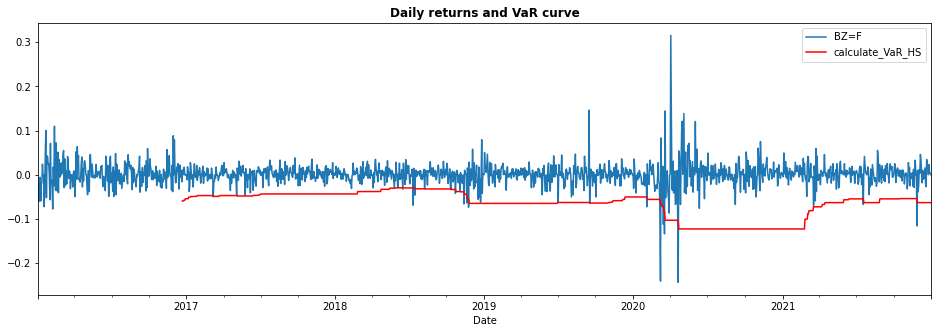

In [ ]:
fig = plt.figure(figsize=(16, 5))

stocks_factors_returns['BZ=F'].dropna().plot()
(-VaR_HS).plot(color="r")

plt.title("Daily returns and VaR curve", weight="bold")
plt.legend()
plt.show()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 39575.65460902155
Iteration:      2,   Func. Count:     16,   Neg. LLF: 27205.337321217427
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4698.581724886284
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4804.785934233258
Iteration:      5,   Func. Count:     40,   Neg. LLF: 4353.9606984957245
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3274.294847866559
Iteration:      7,   Func. Count:     54,   Neg. LLF: 4350.690027517359
Iteration:      8,   Func. Count:     61,   Neg. LLF: 3267.051847867053
Iteration:      9,   Func. Count:     68,   Neg. LLF: 3266.01395745644
Iteration:     10,   Func. Count:     74,   Neg. LLF: 3265.941520380944
Iteration:     11,   Func. Count:     80,   Neg. LLF: 3265.926465597755
Iteration:     12,   Func. Count:     86,   Neg. LLF: 3265.925897816618
Iteration:     13,   Func. Count:     92,   Neg. LLF: 3265.925884333933
Iteration:     14,   Func. Count:     97,   Neg. LLF: 3265.9258

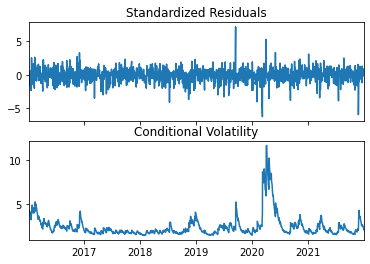

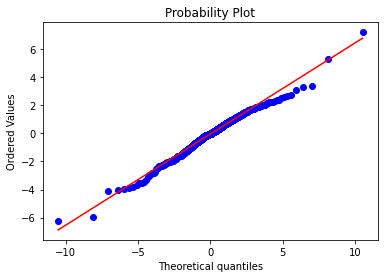

In [ ]:
mdl = arch.arch_model(stocks_factors_returns['BZ=F'].dropna() * 100, dist='t')
res = mdl.fit()
forecast = res.forecast(reindex=False)
print(res)
print(forecast.mean, forecast.variance)
res.plot()
plt.figure()
ss.probplot(res.std_resid, dist=ss.t(df=res.params['nu']), plot=plt);

#### 2.1 Normal distribution model

In [ ]:
# use scipy.stats.norm
def calculate_VaR_normal(returns, alpha):
    mu, std = ss.norm.fit(returns)
    return - ss.norm.ppf(1 - alpha, mu, std)


VaR_norm = calc_VaR(stocks_factors_returns['BZ=F'].dropna(), calculate_VaR_normal, 252, alpha)
VaR_norm

Date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
                ...   
2021-12-27    0.044670
2021-12-28    0.044689
2021-12-29    0.044609
2021-12-30    0.044559
2021-12-31    0.044568
Name: calculate_VaR_normal, Length: 1564, dtype: float64

In [ ]:
import tqdm
def calculate_VaR_parametric(returns, alpha, family=ss.norm):
    params = family.fit(returns)
    return -family.ppf(1 - alpha, *params)


VaR_t = calc_VaR(stocks_factors_returns['BZ=F'].dropna(), calculate_VaR_parametric, 252, alpha, family=ss.t, progress=tqdm.tqdm)
VaR_t

100%|██████████| 1312/1312 [00:56<00:00, 23.20it/s]


Date
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
                ...   
2021-12-27    0.053069
2021-12-28    0.052719
2021-12-29    0.052918
2021-12-30    0.053035
2021-12-31    0.053366
Name: calculate_VaR_parametric, Length: 1564, dtype: float64

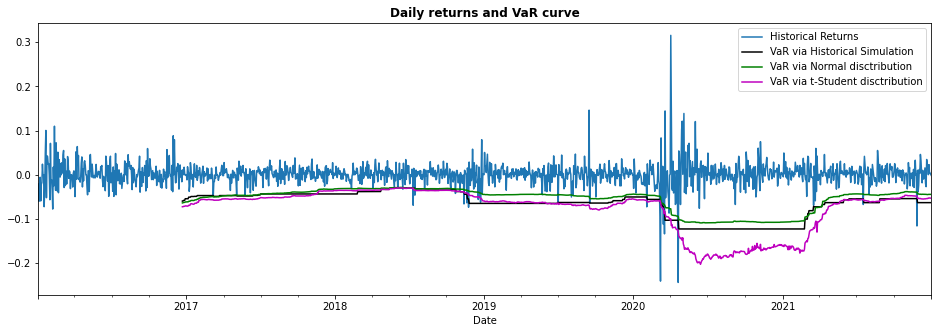

In [ ]:
# compare estimations of different VaR models
fig = plt.figure(figsize=(16, 5))
stocks_factors_returns['BZ=F'].dropna().plot()
(-VaR_HS).plot(color="k")
(-VaR_norm).plot(color="g")
(-VaR_t).plot(color="m")
plt.title("Daily returns and VaR curve", weight="bold")
plt.legend(
    [
        "Historical Returns",
        "VaR via Historical Simulation",
        "VaR via Normal disctribution",
        "VaR via t-Student disctribution",
    ]
)
plt.show()

#### 2.1. Risk Factor Models (Zero Coupon Curve) for Bonds

# Calculate VaR with the historical method

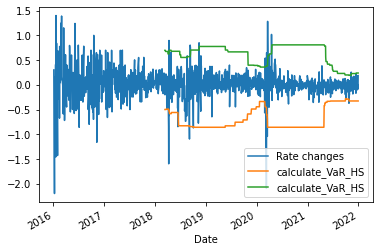

In [ ]:
diffs = bonds_returns['Price0'].copy().rename('Rate changes')  # rates.diff().dropna()
VaR_lower = calc_VaR(diffs, calculate_VaR_HS, 252, alpha)
VaR_upper = - calc_VaR(diffs, calculate_VaR_HS, 252, 1-alpha)

diffs.plot()
(-VaR_lower).plot()
VaR_upper.plot()
plt.legend()

## Fair value of assets in the portfolio

#### Valuation for bonds through duration

In [ ]:
current_rates = bonds_risk_factors.loc[bonds_risk_factors.index.max()]
current_rates.index = current_rates.index.str.replace('period_', '').astype(float)
print(current_rates)

0.25     0.0740
0.50     0.0781
0.75     0.0804
1.00     0.0818
2.00     0.0835
3.00     0.0840
5.00     0.0844
7.00     0.0845
10.00    0.0844
15.00    0.0843
20.00    0.0843
30.00    0.0844
Name: 2021-12-30 00:00:00, dtype: float64


In [ ]:
def bond_cashflows(maturity, coupon_rate, coupon_frequency):
    """
Generate the cash flow stream for a coupon bond
 with a fixed coupon rate and a single repayment
  of the principal at the end of the term.
    
    Parameters
    ----------
    maturity : float
        time to bond maturity (years)
    coupon_rate : float
        bond coupon rate per year (fraction)
    coupon_frequency : int
        number of payments per year (0 for a zero-coupon bond)
    
    Returns
    -------
    pd.Series with
        index : float
            the times to cashflows (years)
        data : float
            payment amount at that time (fraction)
            
    Accrued interest (if any) is returned as negative cash flow at time 0.
    """    
    index = np.linspace(0, maturity, coupon_frequency * maturity + 1)[1:]
    res = pd.Series([coupon_rate / coupon_frequency] * len(index), index=index)
    res.iloc[-1] += 1

    return res

In [ ]:
duration = (bonds_prices_df.index.max() - bonds_prices_df.index.min()).days
bonds_properties={'bond1':{'bond_maturity':duration + 297, 'bond_coupon_rate':7.0, 'bond_frequency':2}, 
                   'bond2':{'bond_maturity':duration + 5057, 'bond_coupon_rate':6.9, 'bond_frequency':2},
                   'bond3':{'bond_maturity':duration + 472, 'bond_coupon_rate':5.5, 'bond_frequency':2},
                    'bond4':{'bond_maturity':duration + 1767, 'bond_coupon_rate':8.15, 'bond_frequency':2},
                    'bond5':{'bond_maturity':duration + 2117, 'bond_coupon_rate':7.05, 'bond_frequency':2}}
bonds_properties_df = pd.DataFrame(bonds_properties).T
bonds_properties_df['bond_maturity'] = bonds_properties_df['bond_maturity'] // 365
bonds_properties_df['bond_coupon_rate'] = bonds_properties_df['bond_coupon_rate'] / 100
bonds_properties_df

,bond_maturity,bond_coupon_rate,bond_frequency
bond1,6.0,0.0700,2.0
bond2,19.0,0.0690,2.0
bond3,7.0,0.0550,2.0
bond4,10.0,0.0815,2.0
bond5,11.0,0.0705,2.0


In [ ]:
bond_maturity = bonds_properties['bond1']['bond_maturity'] // 365
bond_coupon_rate = bonds_properties['bond1']['bond_coupon_rate'] / 100
bond_frequency = bonds_properties['bond1']['bond_frequency']

cashflows = bond_cashflows(bond_maturity, bond_coupon_rate, bond_frequency)
cashflows

0.5    0.035
1.0    0.035
1.5    0.035
2.0    0.035
2.5    0.035
3.0    0.035
3.5    0.035
4.0    0.035
4.5    0.035
5.0    0.035
5.5    0.035
6.0    1.035
dtype: float64

In [ ]:
def discount_factors(interest_rates, period):
    """
    Convert interest rates to discount factor
    
    Parameters:
    ===========
    interest rates : pd.Series with
        index : float
            term to maturity (years)
        data : float
            interest rates per annum as a fraction (0.05 is 5% p.a.)
    period : int | float
        compounding periodicity
            -1 for continuous compounding : d = exp( - r * t)
            0 for simple compounding : d = 1 / (1 + r * t)
            > 0 for compound interest `period` times a year : d = 1 / (1 + r / period) ^ (t * period)
            
    Returns:
    ========
    pd.Series with
        index : float
            term to maturity, equal to interest_rates.index
        data : float
            discount coefficients
    """
    # if period == -1:
    #     tempd = interest_rates*interest_rates.index
    #     return np.exp(tempd)
    # if period == 0:
        
        
    if period == -1:
        d = np.exp( -interest_rates.values * interest_rates.index)
    elif period == 0:
        d = 1 / (1 + interest_rates.values * interest_rates.index)
    elif period > 0:
        d = 1 / (1 + interest_rates.values / period) ** (interest_rates.index * period)
    
    return pd.Series(d, interest_rates.index)

In [ ]:
print(discount_factors(current_rates, 1))
assert np.all(np.isclose(discount_factors(current_rates, 365), discount_factors(current_rates, -1), rtol=0.01))

0.25     0.982311
0.50     0.963098
0.75     0.943651
1.00     0.924385
2.00     0.851809
3.00     0.785077
5.00     0.666887
7.00     0.566752
10.00    0.444739
15.00    0.297001
20.00    0.198158
30.00    0.087966
dtype: float64


In [ ]:
def interpolate_term_structure(interest_rates, terms):
    """
    Interpolate the term structure given by `interest rates` for `terms` to maturity
    Parameters:
    ===========
    interest rates : pd.Series with
        index : float
            term to maturity (years)
        data : float
            interest rates per annum as a fraction (0.05 is 5% p.a.)
    terms : np.array(dtype=float)
        terms to maturity (years) for which we need the interpolated values
        
    Returns:
    ========
    pd.Series with
        index : float
            term to maturity, equal to terms
        data : float
            interpolated rates;
            the values should be equal to the shortest rate for terms less than the shortest given,
            the values should be nan for terms greater than the longest given
        

    """
    return pd.Series(np.interp(terms, interest_rates.index, interest_rates, right = np.nan), index = terms)

In [ ]:
print(interpolate_term_structure(current_rates, [0, 0.25, 1.1, 30, 40]))

0.00     0.07400
0.25     0.07400
1.10     0.08197
30.00    0.08440
40.00        NaN
dtype: float64


In [ ]:
# r = interpolate_term_structure(current_rates, cashflows.index)
# d = discount_factors(r, period)
# P = (cashflows * d).sum()

In [ ]:
def bond_price(cashflows, interest_rates, period=-1):
    """
    Price a bond given by its cash flows by discounting
    
    Parameters:
    ===========
    cashflows : pd.Series with
        index : float
            the times to cashflows (years)
        data : float
            payment amount at that time (fraction)
    interest rates : pd.Series with
        index : float
            term to maturity (years)
        data : float
            interest rates per annum as a fraction (0.05 is 5% p.a.)
    period : int | float
        compounding periodicity
            -1 for continuous compounding
            0 for simple compounding
            > 0 for compound interest `period` times a year
            
    Returns:
    ========
    float
        the bond price
    """
    r = interpolate_term_structure(interest_rates, cashflows.index)
    d = discount_factors(r, period)
    P = (cashflows*d).sum(skipna=False)
    return P
    

bond_price(cashflows, current_rates)

0.9255737282087975

In [ ]:
def bond_duration(cashflows, interest_rates, PV, period=-1):
    """
    Calculate the duratio of a bond given by its cash flows by discounting
    
    Parameters:
    ===========
    cashflows : pd.Series with
        index : float
            the times to cashflows (years)
        data : float
            payment amount at that time (fraction)
    interest rates : pd.Series with
        index : float
            term to maturity (years)
        data : float
            interest rates per annum as a fraction (0.05 is 5% p.a.)
    period : int | float
        compounding periodicity
            -1 for continuous compounding
            0 for simple compounding
            > 0 for compound interest `period` times a year
            
    Returns:
    ========
    float
        the bond duration (years)
    """
    r = interpolate_term_structure(interest_rates, cashflows.index)
    d = discount_factors(r, period)
    P = (cashflows * d).sum(skipna=False)
    dur = (cashflows.index * cashflows * d).sum(skipna=False) / PV
    return dur

# bond_duration(cashflows, current_rates)

In [ ]:
bonds_properties_df

,bond_maturity,bond_coupon_rate,bond_frequency
bond1,6.0,0.0700,2.0
bond2,19.0,0.0690,2.0
bond3,7.0,0.0550,2.0
bond4,10.0,0.0815,2.0
bond5,11.0,0.0705,2.0


In [ ]:
bond_maturity = 19  # years
bond_coupon_rate = 0.069  # as a fraction
bond_frequency = 2  # per year

cashflows = bond_cashflows(bond_maturity, bond_coupon_rate, bond_frequency)
bond_duration(cashflows, current_rates, 0.88996)

9.562371023375167

In [ ]:
np.mean(bonds_returns.quantile(.01) / bonds_prices_df.iloc[-1, :])

-0.012687604703879432

In [ ]:
pca = PCA(1)
np.quantile(pca.fit_transform(bonds_factors_returns.dropna()), 0.99)

0.04865329950319033

In [ ]:
bonds_factors_returns.max(axis=1).quantile(0.99)

0.018852000000000004

In [ ]:
bonds_risk_factors.diff(10).max(axis=1).quantile(0.99)

0.02902999999999983

In [ ]:
# # check the definition of duration
# dr = 1e-10
# D = - (bond_price(cashflows, current_rates + dr) - bond_price(cashflows, current_rates)) / dr / bond_price(cashflows, current_rates)
# print(D)
# assert np.isclose(D, bond_duration(cashflows, current_rates), rtol=1e-5)

In [ ]:
def bond_convexity(cashflows, interest_rates, period=-1):
    """
    Find the convexity of a bond given by its cash flows by discounting
    
    Parameters:
    ===========
    cashflows : pd.Series with
        index : float
            the times to cashflows (years)
        data : float
            payment amount at that time (fraction)
    interest rates : pd.Series with
        index : float
            term to maturity (years)
        data : float
            interest rates per annum as a fraction (0.05 is 5% p.a.)
    period : int | float
        compounding periodicity
            -1 for continuous compounding
            0 for simple compounding
            > 0 for compound interest `period` times a year
            
    Returns:
    ========
    float
        the bond convexity
    """
    r = interpolate_term_structure(interest_rates, cashflows.index)
    d = discount_factors(r, period)
    P = (cashflows*d).sum(skipna=False)
    conv = ((cashflows.index**2)*cashflows*d).sum(skipna=False)/P
    return conv

bond_convexity(cashflows, current_rates)

147.35546024927277

#### Risk factor models for equities using OLS

In [ ]:
# from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [ ]:
def fit_ols(X, y, fit_intercept=False, dropna=True, verbose=True):
    
    if dropna:
        df = pd.merge(X, y, left_index=True, right_index=True)
        df = df.dropna()
        # print(df.columns)
        X, y = df[X.columns.values], df[y.name]

    # print(X)

    if fit_intercept:
        X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    if verbose:
        display(results.summary())
    return results

In [ ]:
fit_ols(X=stocks_factors_returns.iloc[2:,:], 
        y=stocks_prices_returns.iloc[2:,5], fit_intercept=False, verbose=True, dropna=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                GAZP.ME   R-squared (uncentered):                   0.542
Model:                            OLS   Adj. R-squared (uncentered):              0.541
Method:                 Least Squares   F-statistic:                              615.3
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                   6.64e-264
Time:                        18:27:03   Log-Likelihood:                          4939.0
No. Observations:                1564   AIC:                                     -9872.
Df Residuals:                    1561   BIC:                                     -9856.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BZ=F          -0.0017      0.010     -0.161      0.872      -0.022       0.019
IMOEX.ME       1.0535      0.026     40.749      0.000       1.003       1.104
USDRUB=X      -0.0122      0.030     -0.404      0.686      -0.071       0.047
==============================================================================
Omnibus:                     1092.686   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48398.151
Skew:                           2.711   Prob(JB):                         0.00
Kurtosis:                      29.707   Cond. No.                         3.10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

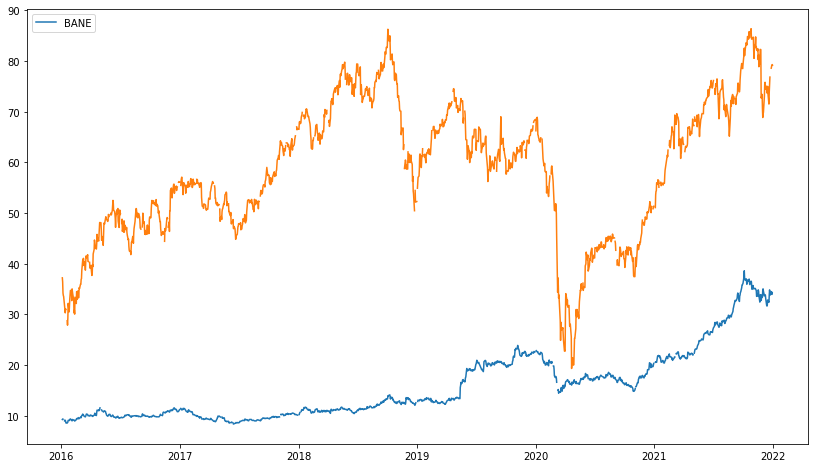

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(stock_prices_df['GAZP.ME'] / 10, label='BANE') 
plt.plot(stock_risk_factors['BZ=F'])
plt.legend()

[]

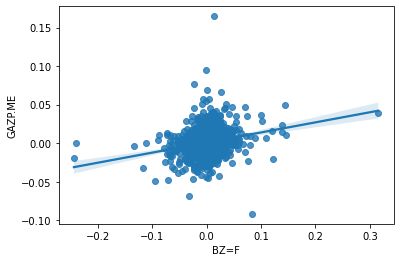

In [ ]:
tmp = pd.concat([stocks_prices_returns, stocks_factors_returns], axis=1)
sns.regplot(y=tmp['GAZP.ME'], x=tmp['BZ=F']).plot(kind='scatter')

In [ ]:
price_sens = pd.DataFrame()

for ticker in stocks_prices_returns.columns:
    model = fit_ols(X=stocks_factors_returns.iloc[2:].fillna(method='ffill'), 
                        y=stocks_prices_returns[ticker].iloc[2:,].fillna(method='ffill'), 
                        fit_intercept=False, verbose=False)
    
    res = model.params
    # res.loc['R^2'] = model.rsquared
    price_sens[ticker] = res
    
price_sens = price_sens.T
print(price_sens)

              BZ=F  IMOEX.ME  USDRUB=X
AFKS.ME  -0.007781  0.916492 -0.048823
AFLT.ME  -0.007492  0.748785 -0.070201
CBOM.ME   0.009061  0.419584 -0.025520
CHF=X     0.006519  0.003390  0.032425
EURRUB=X -0.008095  0.006296  0.852285
GAZP.ME  -0.001671  1.053472 -0.012181
GMKN.ME  -0.060311  0.928357 -0.017415
IRAO.ME  -0.019286  0.747675 -0.144224
MOEX.ME   0.002651  0.657903  0.060689
POLY.ME  -0.075006  0.441638  0.022327
SBER.ME  -0.001806  1.279172 -0.062943
VTBR.ME   0.002218  0.890863 -0.059810


### Investment Portfolio Composition and Risk Evaluation

4. Calculate the portfolio risk for each trading day using the available historical data for 1-day and 10-day horizons.

To accomplish this:

a. Choose risk measures such as Value-at-Risk at a confidence level of 99% and Expected Shortfall at a confidence level of 97.5%.

b. Construct a sample of risk factor distributions based on the dynamics models.

c. Generate a sample of portfolio values based on the sample of risk factor values. The portfolio is assumed to be rebalanced daily to maintain the specified proportions. Use the previous day's prices to determine the composition of the portfolio in terms of financial instruments.

d. Calculate the required risk measures based on the constructed sample.

#### Bonds

In [ ]:
# convert the base
current_bond_prices = bonds_prices_df.loc[bonds_prices_df.index.max()] / 100
current_bond_prices

Price0    0.99100
Price1    0.88996
Price2    0.98387
Price3    0.99601
Price4    0.94348
Name: 2021-12-30 00:00:00, dtype: float64

In [ ]:
# 10  mln - investing in each type of bond
# 1000  - face value of each bond

portfolio = 1e7 / 1000 // current_bond_prices

portfolio_composition = pd.Series(portfolio)  # composition based on the number of shares
portfolio_price = portfolio_composition @ current_bond_prices
portfolio_weights = (portfolio_composition * current_bond_prices) / portfolio_price
portfolio

Price0    10090.0
Price1    11236.0
Price2    10163.0
Price3    10040.0
Price4    10599.0
Name: 2021-12-30 00:00:00, dtype: float64

[0.84031117]


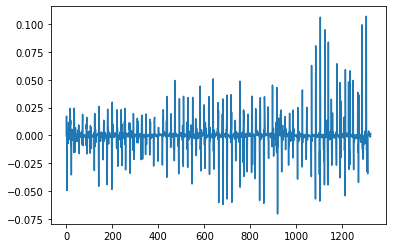

In [ ]:
pca = PCA(1).fit(bonds_factors_returns.dropna())
print(pca.explained_variance_ratio_)
plt.plot(pca.transform(bonds_factors_returns.dropna()))

In [ ]:
from tqdm import tqdm

portfolio D = 6.62
VaR is 1.25%


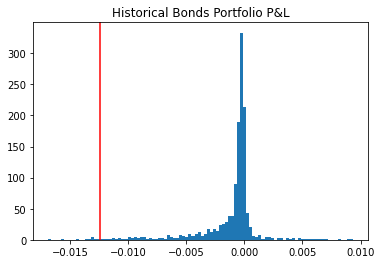

In [ ]:
def calculate_bonds_VaR(df):
    """
    Params:

        df: pd.DataFrame - risk factors for bonds
    """
    
    df = df.copy()
    df.columns = df.columns.str.replace('period_', '').astype(float)
    days_in_history = df.shape[0] - 1
    risk_factor = bonds_risk_factors.diff(1).max(axis=1)

    
    # Flows and durations for all bonds in the portfolio
    cashflows = []
    durations = []
    for b in range(5):
        bond_maturity, bond_coupon_rate, bond_frequency = bonds_properties_df.iloc[b]
        cashflow = bond_cashflows(int(bond_maturity), bond_coupon_rate, int(bond_frequency))
        duration = bond_duration(cashflow, current_rates, current_bond_prices.iloc[b])
        cashflows.append(cashflow)
        durations.append(duration)
    
    D = portfolio_weights.values @ np.array(durations)
    print('portfolio D =', round(D, 2))
    # Simulate chages in the portfolio value
    portfolio_price_delta = []
    for i in range(days_in_history):  # iterate over all the days of history
        delta = -D * risk_factor.iloc[i+1] / 10
        portfolio_price_delta.append(delta)

    #     # for j in range(5):  # for each bons in our portfolio
    #         # today_price = bond_price(cashflows[j], df.iloc[-1, :], 0)
    #         # tomorrow_price = bond_price(cashflows[j], df.iloc[-1, :] + df.diff().iloc[i + 1, :], 0)
    #         # delta.append(tomorrow_price - today_price)

    VaR = -np.quantile(np.array(portfolio_price_delta), 0.01)

    plt.hist(portfolio_price_delta, 100)
    plt.axvline(-VaR, color="r")
    plt.title("Historical Bonds Portfolio P&L")
    print(f"VaR is {VaR*100:.2f}%")
    return portfolio_price_delta

res = calculate_bonds_VaR(bonds_risk_factors)

#### Equities 

In [ ]:
current_stock_prices = stock_prices_df.iloc[-2,:]
current_stock_prices

AFKS.ME        23.396999
AFLT.ME        58.980000
CBOM.ME         6.856000
CHF=X           0.913600
EURRUB=X       84.025497
GAZP.ME       342.470001
GMKN.ME     21389.966797
IRAO.ME         4.275000
MOEX.ME       152.770004
POLY.ME      1309.000000
SBER.ME       293.489990
VTBR.ME         0.048200
Name: 2021-12-30 00:00:00, dtype: float64

In [ ]:
portfolio = {ticker: 1e6 // current_stock_prices[ticker] for ticker in stock_prices_df.columns[:-2]}
for ticker in stock_prices_df.columns[-2:]:
    portfolio[ticker] = 1e7 / current_stock_prices[ticker]

portfolio_composition = pd.Series(portfolio)  # the portfolio composition
portfolio_price = portfolio_composition @ current_stock_prices
portfolio_weights = (portfolio_composition * current_stock_prices) / portfolio_price
portfolio_sensitivities = portfolio_weights @ price_sens  # Variation in the portfolio value in response to fluctuations in risk factors 

In [ ]:
print(price_sens)

              BZ=F  IMOEX.ME  USDRUB=X
AFKS.ME  -0.007781  0.916492 -0.048823
AFLT.ME  -0.007492  0.748785 -0.070201
CBOM.ME   0.009061  0.419584 -0.025520
CHF=X     0.006519  0.003390  0.032425
EURRUB=X -0.008095  0.006296  0.852285
GAZP.ME  -0.001671  1.053472 -0.012181
GMKN.ME  -0.060311  0.928357 -0.017415
IRAO.ME  -0.019286  0.747675 -0.144224
MOEX.ME   0.002651  0.657903  0.060689
POLY.ME  -0.075006  0.441638  0.022327
SBER.ME  -0.001806  1.279172 -0.062943
VTBR.ME   0.002218  0.890863 -0.059810


In [ ]:
portfolio_weights

AFKS.ME     0.033353
AFLT.ME     0.033351
CBOM.ME     0.033353
CHF=X       0.033353
EURRUB=X    0.033353
GAZP.ME     0.033342
GMKN.ME     0.032817
IRAO.ME     0.033353
MOEX.ME     0.033349
POLY.ME     0.033312
SBER.ME     0.333532
VTBR.ME     0.333532
dtype: float64

In [ ]:

# portfolio_dollar_composition = portfolio_composition * current_stock_prices
# print(portfolio_dollar_composition)

# portfolio_dollar_sensitivities = portfolio_dollar_composition @ df
# portfolio_dollar_sensitivities

In [ ]:
w = portfolio_sensitivities
w

BZ=F       -0.005211
IMOEX.ME    0.920814
USDRUB=X   -0.019276
dtype: float64

In [ ]:
sigma = np.sqrt(w.T @ stocks_factors_returns.cov() @ w)
ss.norm.ppf(q=0.99, loc=0, scale=sigma)

0.022663198011286047

#### The delta-normal method to measure VaR

In [ ]:
sigma = np.sqrt(w.T @ stock_risk_factors.pct_change(1).cov() @ w)
ss.norm.ppf(q=0.99, loc=0, scale=sigma) * 100

2.2663198011286045

#### Historical method

In [ ]:
def calculate_VaR_HS(returns, alpha):
    return -np.percentile(returns.values, (1 - alpha) * 100)

calculate_VaR_HS(stock_risk_factors.pct_change(1).dropna() @ w, 0.99) * 100

2.87155098810837

### Calculate the Value at Risk (VaR) for a total portfolio of stocks and bonds

#### For 1 day

In [ ]:
portfolio_bond = 1e7 / 1000 // current_bond_prices

portfolio_bond_composition = pd.Series(portfolio_bond)  # composition based on the number of shares
portfolio_bond_price = portfolio_bond_composition @ current_bond_prices
portfolio_bond_weights = (portfolio_bond_composition * current_bond_prices) / portfolio_bond_price

bond only VaR at 99% = 1.25%
stock only VaR at 99% = 2.68%
total VaR is 1.17%
total ES is 1.22%


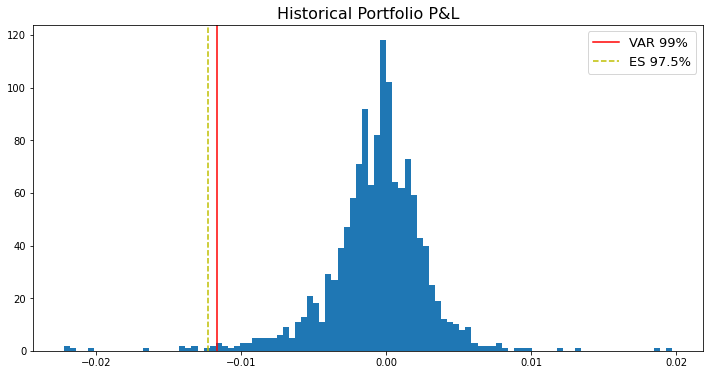

In [ ]:
def calculate_total_VaR(bond_df, stock_df, 
                        bond_weights, stock_sensitivity, verbose=True):
    """
    :param bond_risk_factors: DataFrame with increments of risk factors for bonds.
    :param stock_risk_factors: DataFrame with increments of risk factors for stocks.
    :param bond_weights: Series containing weights in the bond portfolio.
    :param stock_sensitivity: Series containing sensitivities of stocks in the portfolio.
    """

    bond_df = bond_df.copy()
    bond_df.columns = bond_df.columns.str.replace('period_', '').astype(float)
    days_in_history = bond_df.shape[0] - 1
    risk_factor = bond_df.max(axis=1)  # biggest interest rate change in a day
    
    # Calculate flows and durations for all bonds in our portfolio
    cashflows = []
    durations = []
    for b in range(5):
        bond_maturity, bond_coupon_rate, bond_frequency = bonds_properties_df.iloc[b]
        cashflow = bond_cashflows(int(bond_maturity), bond_coupon_rate, int(bond_frequency))
        duration = bond_duration(cashflow, current_rates, current_bond_prices.iloc[b])
        cashflows.append(cashflow)
        durations.append(duration)

    D = bond_weights.values @ np.array(durations)
    # print('bond portfolio D =', round(D, 2))

    # Simulating the portfolio price change
    portfolio_price_delta = []
    stock = []
    bond = []
    for i in range(days_in_history):  # iterate over all days
        bond_delta = -D * risk_factor.iloc[i] / 10
        stock_delta = stock_df.iloc[i] @ stock_sensitivity
        total_delta = (bond_delta * 5e7 + stock_delta * 2e7) / 7e7
        portfolio_price_delta.append(total_delta)
        stock.append(stock_delta)
        bond.append(bond_delta)

    portfolio_price_delta = np.array(portfolio_price_delta)

    VaR_99 = -np.quantile(np.array(portfolio_price_delta), 1 - 0.99)
    VaR_975 = -np.quantile(np.array(portfolio_price_delta), 1 - 0.975)
    ES_975 = -np.mean(portfolio_price_delta[portfolio_price_delta < -VaR_975])

    if verbose:
        print(f'bond only VaR at 99% = {round(-np.quantile(bond, 0.01) * 100, 2)}%')
        print(f'stock only VaR at 99% = {round(-np.quantile(stock, 0.01) * 100, 2)}%')
    
        # Plots
        plt.figure(figsize=(12, 6))
        plt.hist(portfolio_price_delta, 100)
        plt.axvline(-VaR_99, color="r", label='VAR 99%')
        plt.axvline(-ES_975, color="y", linestyle="dashed", label='ES 97.5%')
        plt.title("Historical Portfolio P&L", fontsize=16)
        plt.legend(fontsize=13)
        print(f"total VaR is {VaR_99 * 100:.2f}%")
        print(f"total ES is {ES_975 * 100:.2f}%")

    return portfolio_price_delta


res = calculate_total_VaR(bonds_factors_returns.dropna(), stocks_factors_returns.dropna(), 
                            portfolio_bond_weights, w)

#### For 10 Days

bond only VaR at 99% = 1.84%
stock only VaR at 99% = 6.27%
total VaR is 2.21%
total ES is 2.71%


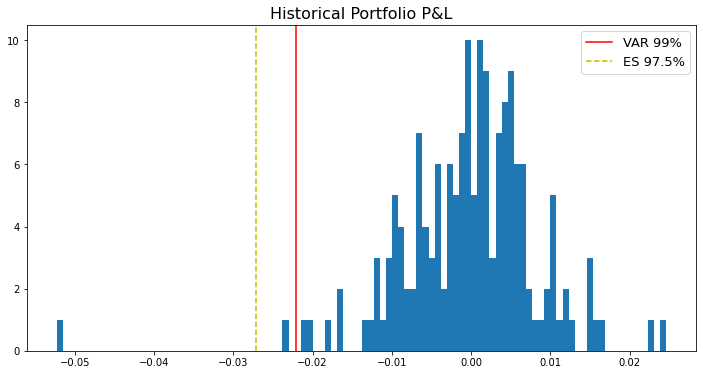

In [ ]:
res = calculate_total_VaR(bonds_risk_factors.iloc[::8,].diff().dropna(), 
                            stock_risk_factors.iloc[::8,].pct_change().dropna(), 
                            portfolio_bond_weights, w)

## Validate our estimation

In [ ]:
class ModelValidation():
    def __init__(self):
        self.stock_tickers = list(stock_prices_df.columns[stock_prices_df.columns.str.find('=') < 0])
        self.fx_tickets = list(stock_prices_df.columns[stock_prices_df.columns.str.find('=') > 0])
        
        stock_prices = stock_prices_df.loc[:, self.stock_tickers + self.fx_tickets].dropna()
        bonds_prices = bonds_prices_df.dropna()
        
        common_dates = set(stock_prices.index).intersection(set(bonds_prices.index))
        self.stock_prices = stock_prices.loc[common_dates].sort_index()
        self.bond_prices = bonds_prices.loc[common_dates].sort_index()

        self.bonds_factors = bonds_risk_factors.loc[common_dates].sort_index()
        self.stock_factors = stock_risk_factors.loc[common_dates].sort_index()

    def get_bonds_portfolio_delta(self, last_day_index, step=1):
        bonds_prices_df = self.bond_prices
        today_prices = bonds_prices_df.iloc[last_day_index - step] / 100
        next_period_price = bonds_prices_df.iloc[last_day_index] / 100

        current_portfolio = 1e7 / 1000 // today_prices
        current_portfolio_price = current_portfolio @ today_prices * 1000
        next_period_portfolio_price = current_portfolio @ next_period_price * 1000
        
        portfolio_delta = current_portfolio_price - next_period_portfolio_price
        portfolio_return = portfolio_delta / current_portfolio_price
        return portfolio_delta


    def get_stocks_portfolio_delta(self, last_day_index, step=1):
        today_prices = self.stock_prices.iloc[last_day_index - step]
        next_period_price = self.stock_prices.iloc[last_day_index]

        current_portfolio = {ticker: 1e6 // today_prices[ticker] for ticker in self.stock_tickers}
        for ticker in self.fx_tickets:
            current_portfolio[ticker] = 1e7 / current_stock_prices[ticker]
        current_portfolio = pd.Series(current_portfolio)
        
        current_portfolio_price = current_portfolio @ today_prices
        next_period_portfolio_price = current_portfolio @ next_period_price
        
        portfolio_delta = current_portfolio_price - next_period_portfolio_price
        portfolio_return = portfolio_delta / current_portfolio_price
        return portfolio_delta


    def historical_portfolio_returns(self):
        returns = []
        whole_portfolio_price = 10 * 1e6 + 2 * 1e7 + 5 * 1e7

        for i in range(1, self.stock_prices.shape[0]):
            stock_money_delta = self.get_stocks_portfolio_delta(i)
            bond_money_delta = self.get_bonds_portfolio_delta(i)
            total_money_delta = stock_money_delta + bond_money_delta
            
            total_return = total_money_delta / whole_portfolio_price
            returns.append(total_return)
        return np.array(returns)


    def historical_stocks_returns(self):
        returns = []
        whole_portfolio_price = 10 * 1e6 + 2 * 1e7
        for i in range(1, self.stock_prices.shape[0]):
            stock_money_delta = self.get_bonds_portfolio_delta(i)            
            total_return = stock_money_delta / whole_portfolio_price
            returns.append(total_return)
        return np.array(returns)


    def historical_bonds_returns(self):
        returns = []
        whole_portfolio_price = 5 * 1e7
        for i in range(1, self.stock_prices.shape[0]):
            bond_money_delta = self.get_bonds_portfolio_delta(i)            
            total_return = bond_money_delta / whole_portfolio_price
            returns.append(total_return)
        return np.array(returns)


    def historical_daily_VaR(self, window=252):
        res = []
        for i in tqdm(range(self.stock_prices.shape[0] - window)):

            simulation = calculate_total_VaR(self.bonds_factors.diff().dropna().iloc[i:i+window, :], 
                                            self.stock_factors.pct_change().dropna().iloc[i:i+window, :], 
                                            portfolio_bond_weights, w, verbose=False)
            daily_var = np.quantile(simulation, 0.01)
            res.append(daily_var)
        
        self.model_vars = pd.Series(res, index=self.stock_factors.index[window:])
        return self.model_vars
                            

    def plot_VaR_borders(self, window=252):
        hist_returns = pd.Series(self.historical_portfolio_returns(), 
                                index=validation.bonds_factors.index[1:])

        plt.figure(figsize=(15, 6))
        plt.plot(hist_returns)
        plt.plot(self.model_vars, color='r', label='Model VaR 99%')
        plt.plot(hist_returns.rolling(window).apply(lambda x: x.quantile(0.01)), label='Historical VaR 99%')
        plt.title('Portfolio VaR comparison', fontsize=17)
        plt.legend(fontsize=12)
        plt.show()


validation = ModelValidation()

In [ ]:
validation.historical_daily_VaR(180)

100%|██████████| 1133/1133 [01:55<00:00,  9.85it/s]


Date
2016-11-08   -0.010183
2016-11-10   -0.010183
2016-11-11   -0.009979
2016-11-14   -0.009979
2016-11-15   -0.008681
                ...   
2021-12-24   -0.010788
2021-12-27   -0.010788
2021-12-28   -0.010788
2021-12-29   -0.010788
2021-12-30   -0.010788
Length: 1133, dtype: float64

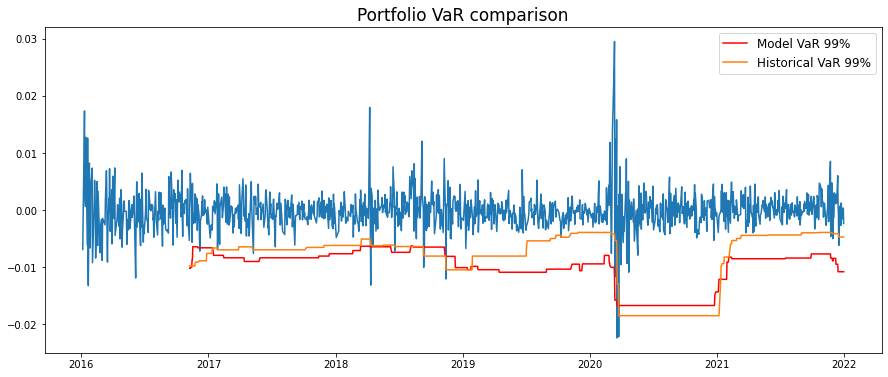

In [ ]:
validation.plot_VaR_borders(180)

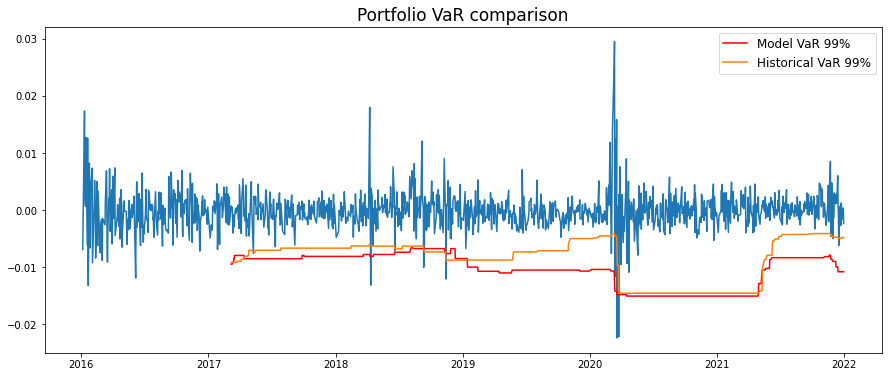

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(hist_returns)
plt.plot(validation.bonds_factors.index[252:], tmp, color='r', label='Model VaR 99%')
plt.plot(hist_returns.rolling(252).apply(lambda x: x.quantile(0.01)), label='Historical VaR 99%')
plt.title('Portfolio VaR comparison', fontsize=17)
plt.legend(fontsize=12)
plt.show()

In [ ]:
np.quantile(validation.historical_bonds_returns(), 0.01) * 100

-1.1059863670000005

In [ ]:
np.quantile(validation.historical_stocks_returns(), 0.01) * 100

-1.8433106116666673

In [ ]:
np.quantile(validation.historical_portfolio_returns(), 0.01) * 100

-0.9073041415106697

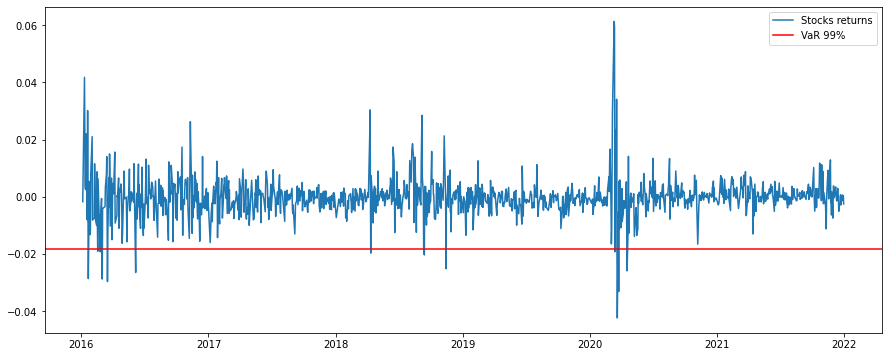

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(validation.bond_prices.index[1:], validation.historical_stocks_returns(), label='Stocks returns')
plt.axhline(y=-1.843 / 100, color='r', label='VaR 99%')
plt.legend()

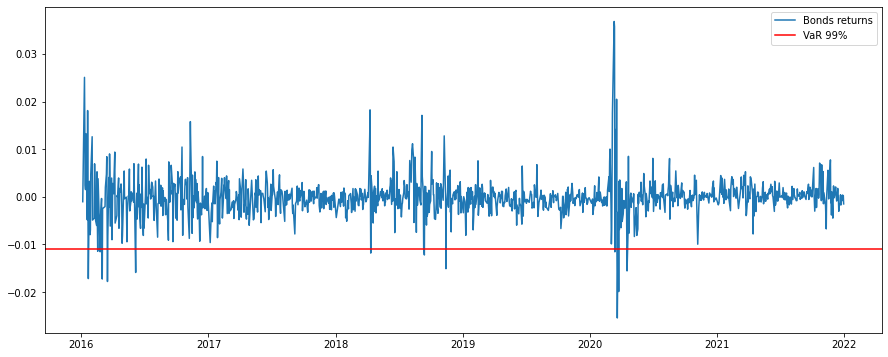

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(validation.bond_prices.index[1:], validation.historical_bonds_returns(), label='Bonds returns')
plt.axhline(y=-1.106 / 100, color='r', label='VaR 99%')
plt.legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2f6ae8c7-7661-4f9b-91a6-1bc36c189c78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>